# 0.Import

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score,roc_auc_score,classification_report



# I. Tiền xử lý dữ liệu

In [2]:
np.set_printoptions(precision=4, suppress=True)
def input_data():
    while True:
        file_path = input("Vui lòng nhập đường dẫn đến file (.csv hoặc .xlsx): ").strip('"').replace("\\", "/")
        try:
            if file_path.endswith('.csv'):
                data = pd.read_csv(file_path)
                print("Dữ liệu từ file CSV đã được đọc thành công.")
                break  # Thoát khỏi vòng lặp nếu đọc file thành công
            elif file_path.endswith('.xlsx'):
                data = pd.read_excel(file_path)
                print("Dữ liệu từ file Excel đã được đọc thành công.")
                print(data.head())
                break  # Thoát khỏi vòng lặp nếu đọc file thành công
            else:
                print("Định dạng file không hợp lệ. Vui lòng nhập file có định dạng .csv hoặc .xlsx.")
        except FileNotFoundError:
            print("Không tìm thấy file. Vui lòng kiểm tra lại đường dẫn.")
    return data

## 0. Thống kê mô tả dữ liệu

In [3]:
data = pd.read_csv('Car Sales.xlsx - car_data.csv')
data.info()
data.drop(columns=['Phone']).describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Car_id         23906 non-null  object
 1   Date           23906 non-null  object
 2   Customer Name  23905 non-null  object
 3   Gender         23906 non-null  object
 4   Annual Income  23906 non-null  int64 
 5   Dealer_Name    23906 non-null  object
 6   Company        23906 non-null  object
 7   Model          23906 non-null  object
 8   Engine         23906 non-null  object
 9   Transmission   23906 non-null  object
 10  Color          23906 non-null  object
 11  Price ($)      23906 non-null  int64 
 12  Dealer_No      23906 non-null  object
 13  Body Style     23906 non-null  object
 14  Phone          23906 non-null  int64 
 15  Dealer_Region  23906 non-null  object
dtypes: int64(3), object(13)
memory usage: 2.9+ MB


,Annual Income,Price ($)
count,2.390600e+04,23906.000000
mean,8.308403e+05,28090.247846
std,7.200064e+05,14788.687608
min,1.008000e+04,1200.000000
25%,3.860000e+05,18001.000000
50%,7.350000e+05,23000.000000
75%,1.175750e+06,34000.000000
max,1.120000e+07,85800.000000


In [4]:
data.head()

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


In [5]:

data.nunique()

Car_id           23906
Date               612
Customer Name     3021
Gender               2
Annual Income     2508
Dealer_Name         28
Company             30
Model              154
Engine               2
Transmission         2
Color                3
Price ($)          870
Dealer_No            7
Body Style           5
Phone            23804
Dealer_Region        7
dtype: int64

In [6]:
# Cột dạng số
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
print("Cột số:", num_cols)

# Cột dạng phân loại (object/string)
cat_cols = data.select_dtypes(include=['object']).columns
print("Cột phân loại:", cat_cols)


Cột số: Index(['Annual Income', 'Price ($)', 'Phone'], dtype='object')
Cột phân loại: Index(['Car_id', 'Date', 'Customer Name', 'Gender', 'Dealer_Name', 'Company',
       'Model', 'Engine', 'Transmission', 'Color', 'Dealer_No ', 'Body Style',
       'Dealer_Region'],
      dtype='object')


## 1. Xóa bỏ các trường không cần thiết

Các trường như "Car_id", "Date", "Customer Name"... không có ý nghĩa gì trong mô hình phân loại thì ta có thể loại bỏ đi

In [7]:
def drop_columns(data, column_name):
    if column_name in data.columns:
        data = data.drop(columns=[column_name])
    return data

## 2. Kiểm tra dữ liệu thiếu (null)

In [8]:
def handle_missing_values(data):
    print("Thông tin về dữ liệu thiếu:")
    print(data.isnull().sum())
    tt_missing = data.isnull().sum().sum()
    print(f"Phần trăm dữ liệu thiếu là: {tt_missing/len(data)*100:.2f}%")
    if tt_missing != 0:
        print("\nChọn phương pháp xử lý dữ liệu thiếu:")
        print("1: Loại bỏ các dòng có giá trị thiếu (recommended)")
        print("2: Thay thế giá trị thiếu bằng 0")
        print("3: Thay thế giá trị thiếu bằng trung bình của cột")

        choice = input("Nhập lựa chọn của bạn (1, 2, hoặc 3): ")

        if choice == '1':
            data = data.dropna()
            print(f"\nĐã loại bỏ {tt_missing} dòng có giá trị thiếu.")
        elif choice == '2':
            data = data.fillna(0)
            print(f"\nĐã thay thế {tt_missing} giá trị thiếu bằng 0.")
        elif choice == '3':
            data = data.fillna(data.mean())
            print(f"\nĐã thay thế các giá trị thiếu bằng trung bình biến đó.")
        else:
            print("Lựa chọn không hợp lệ. Không có thay đổi nào được thực hiện.")
    return data

## 3. Xử lý giá trị trùng lặp

In [9]:
def remove_duplicates(data, subset=None, keep='first', verbose=True):
    """
    Hàm loại bỏ các dòng trùng lặp trong DataFrame.

    Parameters:
    - df (pd.DataFrame): Dữ liệu đầu vào
    - subset (list or None): Danh sách các cột để kiểm tra trùng lặp (nếu None, dùng toàn bộ cột)
    - keep (str): 'first' giữ dòng đầu tiên, 'last' giữ dòng cuối cùng, False là loại bỏ tất cả các bản sao
    - verbose (bool): In ra số lượng dòng bị loại bỏ

    Returns:
    - df_cleaned (pd.DataFrame): DataFrame sau khi loại bỏ trùng lặp
    """

    before = data.shape[0]
    data_cleaned = data.drop_duplicates(subset=subset, keep=keep)
    after = data_cleaned.shape[0]

    if verbose:
        print(f"Đã loại bỏ {before - after} dòng trùng lặp.")
    
    return data


## 4. Mã hóa trường phân loại

In [10]:
def create_dum_var(data):
    obj_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
    data_encoded = pd.get_dummies(data, columns=obj_cols, drop_first=True)
    return data_encoded

## 5. Chuẩn hóa các biến số

In [11]:
def standardize_numeric(data):
    numric_cols = data.select_dtypes(include=['int64', 'float']).columns
    scaler = StandardScaler()
    data[numric_cols] = scaler.fit_transform(data[numric_cols])
    return data

# II. Trực quan hóa dữ liệu

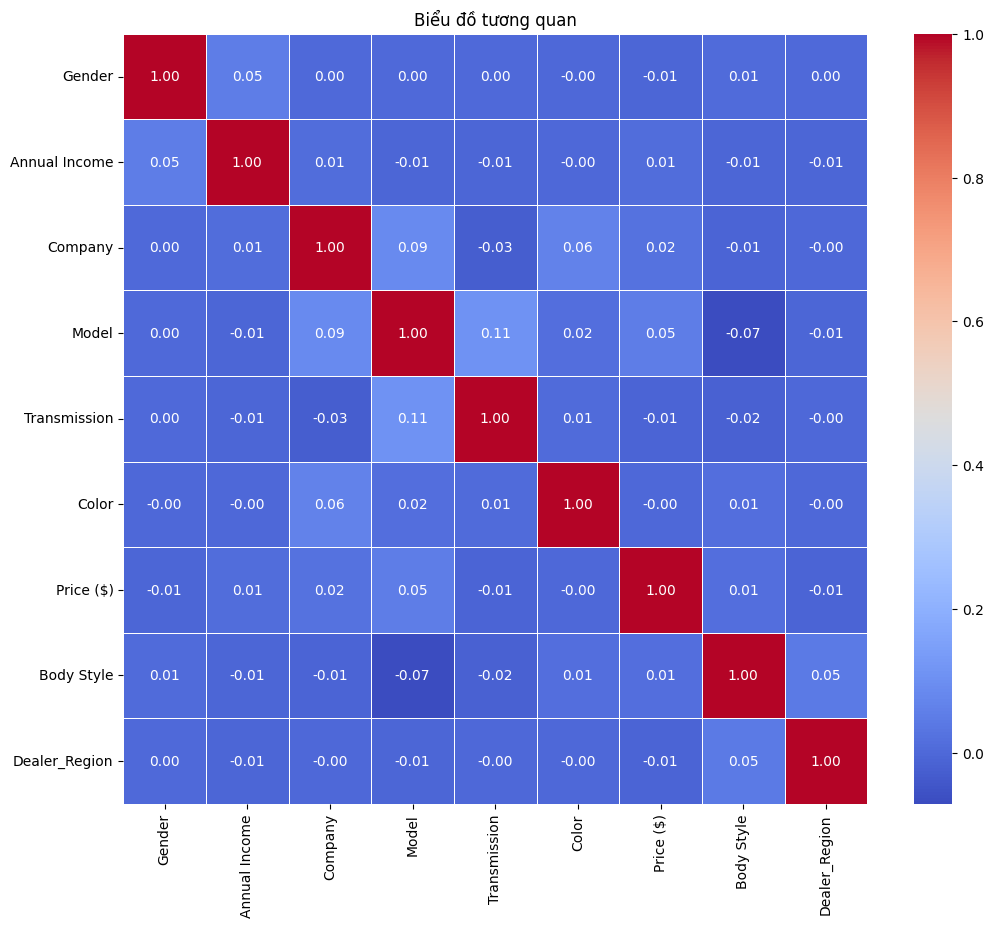

In [12]:
features_to_drop = ['Car_id', 'Date', 'Customer Name', 'Phone', 'Dealer_Name', 'Dealer_No ','Engine']
data = data.drop(columns= features_to_drop)
data_encoded = data.copy()

# Mã hóa các cột kiểu object (chữ) sang số
label_encoders = {}
for col in data_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col].astype(str))
    label_encoders[col] = le  # Lưu nếu muốn inverse_transform sau này

# Tính ma trận tương quan
corr = data_encoded.corr()

# Vẽ heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Biểu đồ tương quan')
plt.show()

#### 1. Phân phối giá xe

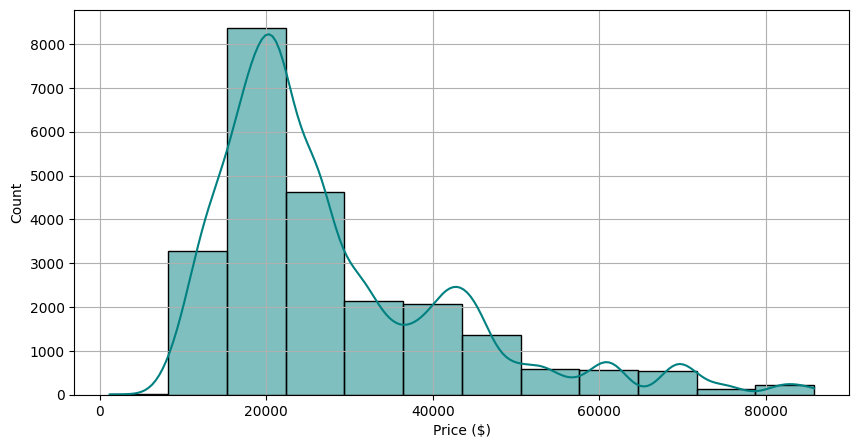

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.subplot(111)
sns.histplot(data=data,x='Price ($)',bins=12,kde=True,color='teal')
plt.grid()
plt.show()

Ta thấy giá xe phân bố không đồng đều và có xu hướng lệch trái chủ yếu tập trung ở mức 15.000 - 25.000 USD

#### 2. Phân phối số lượng xe theo từng hãng xe

C:\Users\Admin\AppData\Local\Temp\ipykernel_18676\59330419.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,y='Company',palette = 'pastel')


<Axes: xlabel='count', ylabel='Company'>

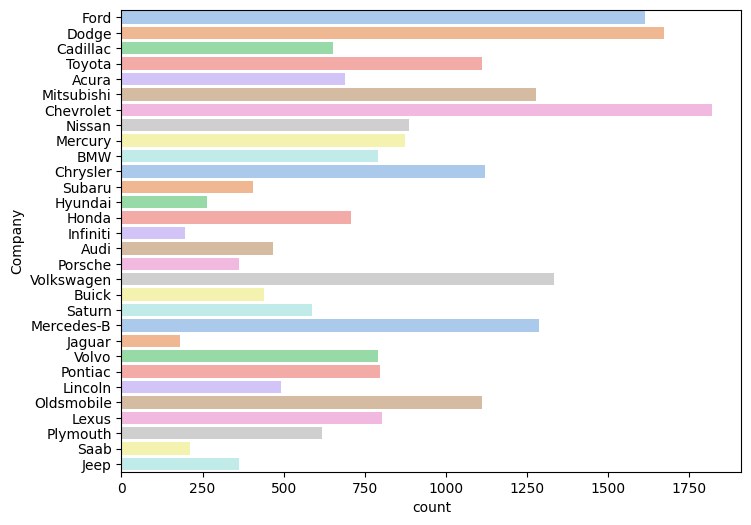

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data,y='Company',palette = 'pastel')

Ta thấy rằng, các công ty có số lượng xe bán ra nhiều nhất là: "Chevrolet", "Dodge", "Ford",... với số lượng bán ra là hơn 1.500 chiếc. Ngược lại đó, các hãng "Jagular", "Infiniti", "Saab" lại có số lượng khá khiêm tốn - dưới 250 chiếc

#### 3. Thu nhập trung bình người mua theo hãng xe

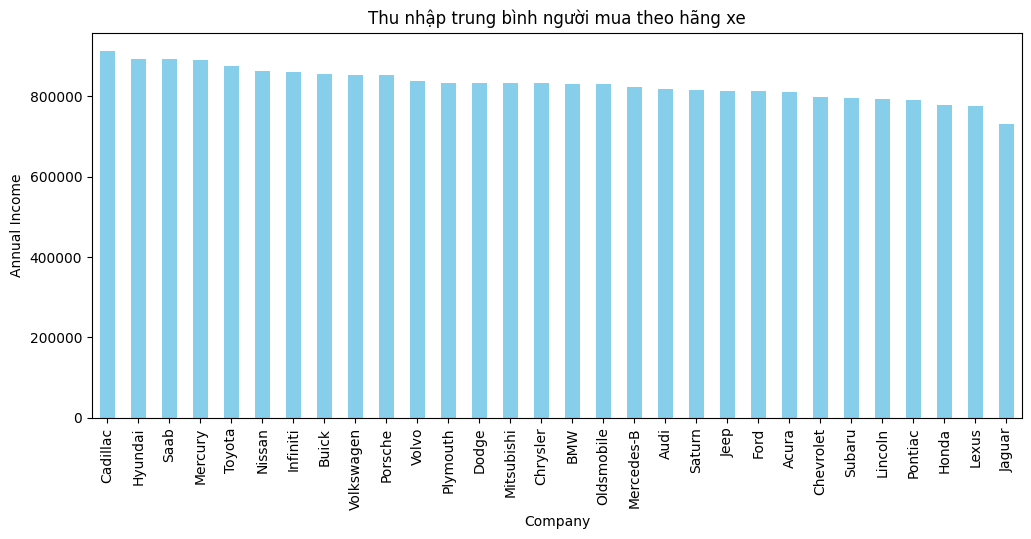

In [15]:
avg_income = data.groupby('Company')['Annual Income'].mean().sort_values(ascending=False)
avg_income.plot(kind='bar', figsize=(12, 5), color='skyblue')
plt.title('Thu nhập trung bình người mua theo hãng xe')
plt.ylabel('Annual Income')
plt.xticks(rotation=90)
plt.show()


Cadillac, Hyundai, Saab là 3 hãng xe có khách hàng sở hữu thu nhập trung bình cao nhất, khoảng 900,000+ đơn vị tiền tệ/năm. 

#### 4. Hãng xe và giới tính khách hàng

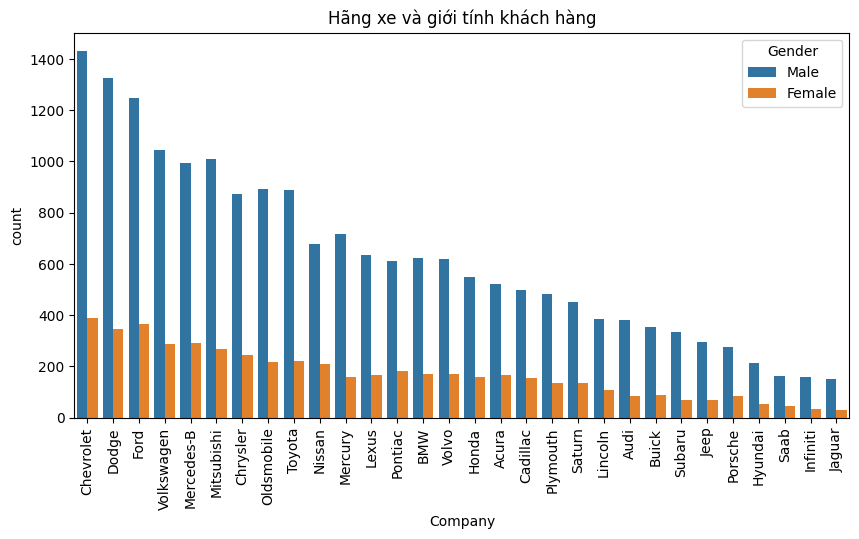

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Company', hue='Gender', order=data['Company'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Hãng xe và giới tính khách hàng')
plt.show()


Nhìn chung thì ở tất cả các hãng xe thì khách hàng chủ yếu là nam giới. Có điều khác nhau ở đây là số lượng xe bán ra cho khách hàng của hãng Dodge nhiều hơn so với hãng Ford. Nhưng đối với nữ thì ngược lại 

# III. Xây dựng mô hình

## 1. Phân tích Tầm quan trọng của Đặc trưng (Feature Importance)


Tầm quan trọng của Đặc trưng (từ mô hình nháp):
         feature  importance
2          Model    0.534552
6      Price ($)    0.243914
7     Body Style    0.099851
5          Color    0.043223
1  Annual Income    0.039900
8  Dealer_Region    0.019951
3         Engine    0.006634
4   Transmission    0.006577
0         Gender    0.005399


C:\Users\Admin\AppData\Local\Temp\ipykernel_18676\1230446606.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette="viridis")


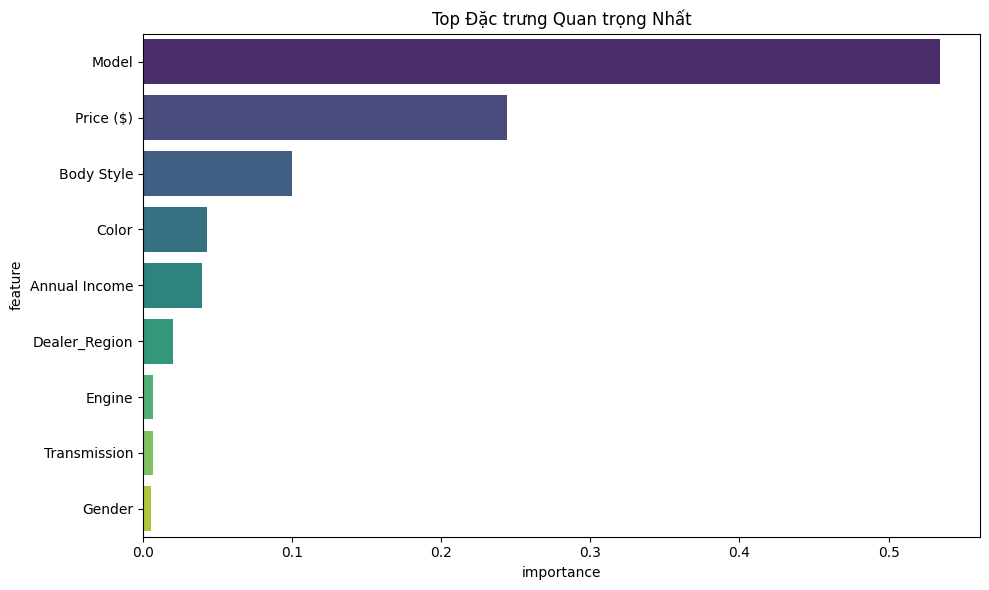


CẢNH BÁO: Đặc trưng 'Model' có tầm quan trọng rất cao (0.53).
Điều này có thể là dấu hiệu rò rỉ dữ liệu hoặc mối quan hệ quá chặt chẽ với biến mục tiêu.


In [17]:
data = pd.read_csv('Car Sales.xlsx - car_data.csv')
features_to_drop_initial = ['Car_id', 'Date', 'Customer Name', 'Phone', 'Dealer_Name', 'Dealer_No ']
    # Loại bỏ các cột không tồn tại khỏi features_to_drop để tránh lỗi
features_to_drop = [col for col in features_to_drop_initial if col in data.columns]
data_for_fi_check = data.drop(columns=features_to_drop, errors='ignore')
# Mã hóa tất cả các cột hạng mục (bao gồm cả biến mục tiêu nếu là hạng mục)
# để đưa vào mô hình
encoders = {}
for col in data_for_fi_check.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    data_for_fi_check[col] = le.fit_transform(data_for_fi_check[col])
    encoders[col] = le # Lưu lại encoder nếu cần

if 'Company' not in data_for_fi_check.columns:
    print("Cột 'Company' không tồn tại hoặc chưa được mã hóa.")
else:
    X_fi = data_for_fi_check.drop('Company', axis=1)
    y_fi = data_for_fi_check['Company']

    if X_fi.empty or len(y_fi) == 0:
        print("Không có dữ liệu X hoặc y để huấn luyện mô hình kiểm tra.")
    else:
        # Huấn luyện mô hình Random Forest nháp
        # Không cần chia train/test ở đây vì mục đích là khám phá trên toàn bộ dữ liệu
        model_fi = RandomForestClassifier(n_estimators=100, random_state=42)
        model_fi.fit(X_fi, y_fi)

        # Lấy tầm quan trọng của đặc trưng
        importances = model_fi.feature_importances_
        feature_names = X_fi.columns
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        print("\nTầm quan trọng của Đặc trưng (từ mô hình nháp):")
        print(feature_importance_df.head(10)) # In ra 10 đặc trưng quan trọng nhất

        # Trực quan hóa
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette="viridis")
        plt.title('Top Đặc trưng Quan trọng Nhất')
        plt.tight_layout()
        plt.show()

        # Kiểm tra nếu có đặc trưng nào đó quá nổi bật
        if not feature_importance_df.empty:
            top_feature = feature_importance_df.iloc[0]
            if top_feature['importance'] > 0.4: # Ngưỡng tùy chỉnh, ví dụ > 50% tổng tầm quan trọng
                print(f"\nCẢNH BÁO: Đặc trưng '{top_feature['feature']}' có tầm quan trọng rất cao ({top_feature['importance']:.2f}).")
                print("Điều này có thể là dấu hiệu rò rỉ dữ liệu hoặc mối quan hệ quá chặt chẽ với biến mục tiêu.")

- Ta thấy rằng biến "Model" có tầm quan trọng khá là cao (53%%) so  với các đặc trưng. Ta sẽ tiến hành kiểm tra thêm
- Ngoài ra có biến "Gender", "Transmission", "Engine" có tầm quan trọng rất thấp, ta có thể bỏ biến này đi

#### Kiểm tra số lượng "Company" duy nhất cho mỗi "Model"

In [18]:

# Loại bỏ các hàng có giá trị thiếu trong 'Model' hoặc 'Company' để kiểm tra chính xác
data_cleaned_for_check = data.dropna(subset=['Model', 'Company'])

# Nhóm theo 'Model' và đếm số lượng 'Company' duy nhất cho mỗi Model
model_to_company_uniqueness = data_cleaned_for_check.groupby('Model')['Company'].nunique()

# Tìm các Model chỉ liên kết với 1 Company
models_with_one_company = model_to_company_uniqueness[model_to_company_uniqueness == 1]

# Tìm các Model liên kết với nhiều hơn 1 Company (nếu có)
models_with_multiple_companies = model_to_company_uniqueness[model_to_company_uniqueness > 1]

print(f"Tổng số Model duy nhất: {data_cleaned_for_check['Model'].nunique()}")
print(f"Số Model chỉ thuộc về 1 Company: {len(models_with_one_company)}")
print(f"Số Model thuộc về >1 Company: {len(models_with_multiple_companies)}")

if len(models_with_multiple_companies) == 0 and data_cleaned_for_check['Model'].nunique() > 0 :
    print("\nPhat hiện: MỖI Model chỉ tương ứng với MỘT Company duy nhất.")
    print("Đây là một dạng rò rỉ dữ liệu tiềm ẩn nếu 'Model' được dùng làm đặc trưng.")
elif len(models_with_multiple_companies) > 0:
    print("\nMột số Model thuộc về nhiều hơn một Company:")
    print(models_with_multiple_companies.head())
    # Bạn có thể kiểm tra thêm:
    # for model_name, num_companies in models_with_multiple_companies.items():
    #     companies_for_model = data_cleaned_for_check[data_cleaned_for_check['Model'] == model_name]['Company'].unique()
    #     print(f"Model '{model_name}' thuộc về các Companies: {list(companies_for_model)}")
else:
    print("\nKhông có dữ liệu Model hoặc Company để kiểm tra.")

# Kiểm tra ngược lại: Mỗi Company có bao nhiêu Model duy nhất (chỉ để tham khảo)
# company_to_model_uniqueness = data_cleaned_for_check.groupby('Company')['Model'].nunique()
# print("\nSố lượng Model duy nhất cho mỗi Company (tham khảo):")
# print(company_to_model_uniqueness.sort_values(ascending=False).head())

Tổng số Model duy nhất: 154
Số Model chỉ thuộc về 1 Company: 153
Số Model thuộc về >1 Company: 1

Một số Model thuộc về nhiều hơn một Company:
Model
Neon    2
Name: Company, dtype: int64


Sau khi phân tích ta thấy, dường như chỉ cần biết thuộc tính của "Model" thì ta có thể biết được chắc chắn thuộc tính "Company" của nó. Ta sẽ tiến hành xóa biến "Model" đi để đảm bảo mô hình không bị overfiting

C:\Users\Admin\AppData\Local\Temp\ipykernel_18676\1703442954.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Model', y='Unique_Companies_Count', data=plot_data, palette="viridis")


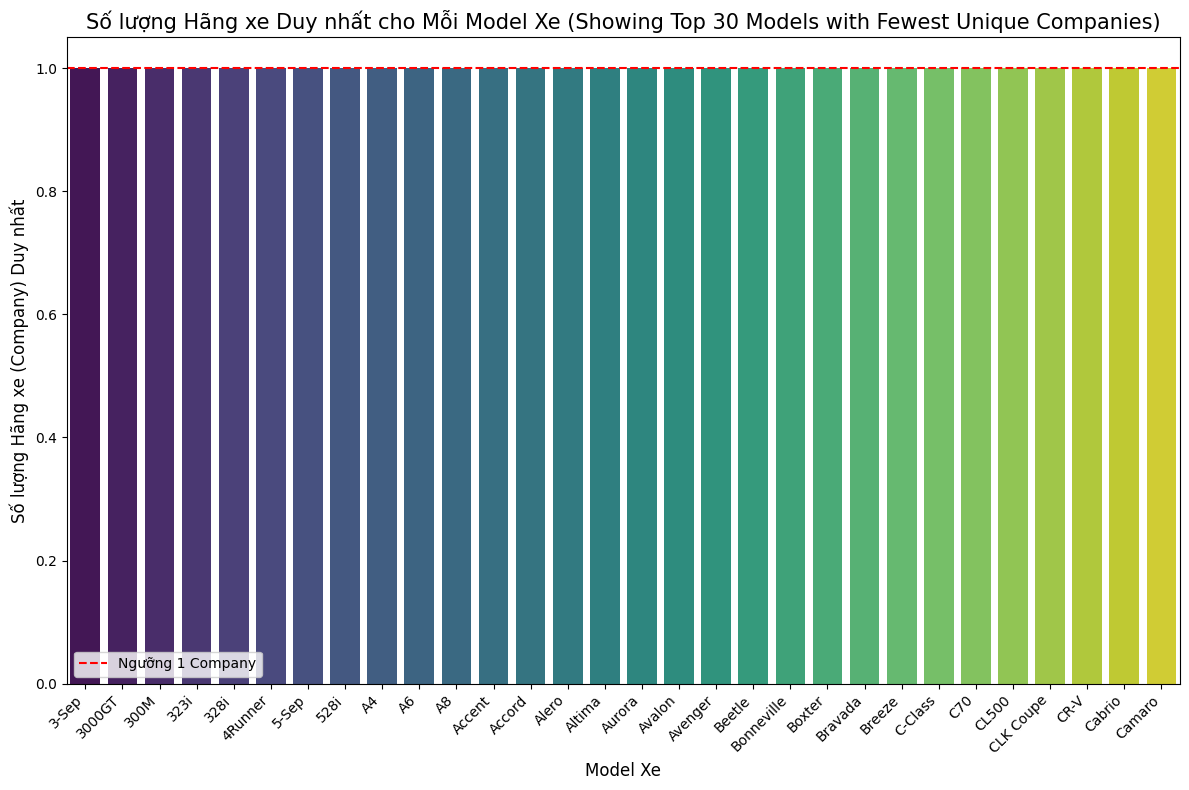


Cảnh báo: Có Model tương ứng với nhiều hơn một Company:
    Model  Unique_Companies_Count
102  Neon                       2


In [19]:
model_company_counts = data.dropna(subset=['Model', 'Company']) \
                           .groupby('Model')['Company'].nunique() \
                           .reset_index(name='Unique_Companies_Count')

# Sắp xếp để biểu đồ dễ nhìn hơn (tùy chọn)
model_company_counts = model_company_counts.sort_values(by='Unique_Companies_Count', ascending=True)

# 2. Vẽ biểu đồ thanh
plt.figure(figsize=(12, 8)) # Điều chỉnh kích thước nếu cần

# Nếu số lượng Model quá lớn, chỉ hiển thị một phần hoặc xoay nhãn
num_models_to_show = 30 # Giới hạn số lượng model hiển thị để tránh biểu đồ quá đông
if len(model_company_counts) > num_models_to_show:
    plot_data = model_company_counts.head(num_models_to_show) # Hiển thị các model có ít company nhất
    # Hoặc plot_data = model_company_counts.sample(num_models_to_show) # Lấy mẫu ngẫu nhiên
    title_suffix = f"(Showing Top {num_models_to_show} Models with Fewest Unique Companies)"
else:
    plot_data = model_company_counts
    title_suffix = ""


barplot = sns.barplot(x='Model', y='Unique_Companies_Count', data=plot_data, palette="viridis")

plt.xlabel("Model Xe", fontsize=12)
plt.ylabel("Số lượng Hãng xe (Company) Duy nhất", fontsize=12)
plt.title(f"Số lượng Hãng xe Duy nhất cho Mỗi Model Xe {title_suffix}", fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=10) # Xoay nhãn trục x để dễ đọc
plt.yticks(fontsize=10)

# Thêm đường tham chiếu y=1
plt.axhline(1, color='red', linestyle='--', linewidth=1.5, label='Ngưỡng 1 Company')
plt.legend()

# Hiển thị giá trị trên mỗi cột (tùy chọn, có thể làm biểu đồ rối nếu nhiều cột)
# for p in barplot.patches:
#     barplot.annotate(format(p.get_height(), '.0f'),
#                      (p.get_x() + p.get_width() / 2., p.get_height()),
#                      ha = 'center', va = 'center',
#                      xytext = (0, 9),
#                      textcoords = 'offset points')

plt.tight_layout() # Tự động điều chỉnh để vừa vặn
plt.show()

# In ra thông báo xác nhận
if all(model_company_counts['Unique_Companies_Count'] == 1):
    print("\nXác nhận từ dữ liệu: Mỗi Model chỉ tương ứng với MỘT Company duy nhất.")
elif any(model_company_counts['Unique_Companies_Count'] > 1):
    offending_models = model_company_counts[model_company_counts['Unique_Companies_Count'] > 1]
    print("\nCảnh báo: Có Model tương ứng với nhiều hơn một Company:")
    print(offending_models)
else:
    print("\nKhông có dữ liệu Model/Company để phân tích hoặc tất cả Model đều có 0 Company (lỗi dữ liệu).")

## 2. Các hàm xử lý mô hình

#### 2.1. Hàm kiểm tra cân bằng lớp

In [20]:
def check_class_balance(y_target, target_name="Target Variable", plot_figsize=(10, 6), suppress_plot=False):
    if isinstance(y_target, np.ndarray):
        y_target_series = pd.Series(y_target, name=target_name)
    elif isinstance(y_target, pd.Series):
        y_target_series = y_target
    else:
        print("Lỗi: y_target phải là pd.Series hoặc np.array.")
        return None
    if y_target_series.empty:
        print("Lỗi: Dữ liệu y_target rỗng.")
        return None
    print(f"\n--- Phân tích Cân bằng Lớp cho Biến '{y_target_series.name or target_name}' ---")
    class_counts = y_target_series.value_counts().reset_index()
    class_counts.columns = ['Class', 'Count']
    class_counts['Percentage (%)'] = (class_counts['Count'] / class_counts['Count'].sum()) * 100
    class_counts = class_counts.sort_values(by='Count', ascending=False)
    print("\nSố lượng và Tỷ lệ phần trăm của mỗi lớp:")
    print(class_counts)
    min_percentage = class_counts['Percentage (%)'].min()
    max_percentage = class_counts['Percentage (%)'].max()
    ratio_min_max = min_percentage / max_percentage if max_percentage > 0 else 0
    print(f"\nLớp có tỷ lệ nhỏ nhất: {class_counts.iloc[-1]['Class']} ({min_percentage:.2f}%)")
    print(f"Lớp có tỷ lệ lớn nhất: {class_counts.iloc[0]['Class']} ({max_percentage:.2f}%)")
    print(f"Tỷ lệ giữa lớp nhỏ nhất và lớn nhất: {ratio_min_max:.2f}")
    if not suppress_plot:
        plt.figure(figsize=plot_figsize)
        barplot = sns.barplot(x='Class', y='Count', data=class_counts, palette='viridis')
        plt.xlabel(f"Các Lớp của '{y_target_series.name or target_name}'", fontsize=12)
        plt.ylabel("Số lượng Mẫu", fontsize=12)
        plt.title(f"Phân bố Số lượng Mẫu cho '{y_target_series.name or target_name}'", fontsize=15)
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.yticks(fontsize=10)
        for p in barplot.patches:
            barplot.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
        plt.tight_layout()
        plt.show()
    return class_counts




#### 2.2 Xử lý Outliter

In [21]:
def detect_and_treat_outliers_iqr(df, column_name, treatment_method='cap', factor=1.5, plot_boxplot=True):
    """
    Phát hiện và xử lý giá trị ngoại lai trong một cột số của DataFrame sử dụng phương pháp IQR.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        column_name (str): Tên của cột số cần kiểm tra.
        treatment_method (str): Phương pháp xử lý ngoại lai:
                                'cap': Thay thế ngoại lai bằng giới hạn trên/dưới (capping).
                                'remove_rows': Loại bỏ các hàng chứa ngoại lai.
                                'impute_median': Thay thế ngoại lai bằng giá trị trung vị của cột.
                                'impute_mean': Thay thế ngoại lai bằng giá trị trung bình của cột.
                                'none': Chỉ phát hiện và báo cáo, không xử lý.
        factor (float): Hệ số nhân với IQR để xác định giới hạn ngoại lai (thường là 1.5).
                        Giá trị lớn hơn (ví dụ: 3.0) sẽ ít nhạy cảm hơn với ngoại lai.
        plot_boxplot (bool): True để vẽ biểu đồ boxplot trước và sau khi xử lý (nếu có xử lý).

    Returns:
        pd.DataFrame: DataFrame đã được xử lý (hoặc bản sao nếu treatment_method='none').
                      Trả về DataFrame gốc nếu cột không tồn tại hoặc không phải là số.
    """
    if column_name not in df.columns:
        print(f"Lỗi: Cột '{column_name}' không tồn tại trong DataFrame.")
        return df.copy() # Trả về bản sao để tránh thay đổi df gốc nếu có lỗi

    if not pd.api.types.is_numeric_dtype(df[column_name]):
        print(f"Lỗi: Cột '{column_name}' không phải là kiểu số. Không thể áp dụng IQR.")
        return df.copy()

    print(f"\n--- Xử lý Giá trị Ngoại lai cho Cột: '{column_name}' (Phương pháp: {treatment_method}) ---")

    # Tạo bản sao để không thay đổi DataFrame gốc trừ khi cần
    df_processed = df.copy()
    original_shape = df_processed.shape

    # Vẽ boxplot trước khi xử lý (nếu được yêu cầu)
    if plot_boxplot:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=df_processed[column_name])
        plt.title(f"Boxplot của '{column_name}' - TRƯỚC khi xử lý ngoại lai")
        plt.show()

    # Tính toán Q1, Q3 và IQR
    Q1 = df_processed[column_name].quantile(0.25)
    Q3 = df_processed[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Xác định giới hạn trên và giới hạn dưới
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"Giới hạn dưới (Lower Bound): {lower_bound:.2f}")
    print(f"Giới hạn trên (Upper Bound): {upper_bound:.2f}")

    # Phát hiện ngoại lai
    outliers_lower = df_processed[df_processed[column_name] < lower_bound]
    outliers_upper = df_processed[df_processed[column_name] > upper_bound]
    num_outliers = len(outliers_lower) + len(outliers_upper)

    if num_outliers == 0:
        print("Không tìm thấy giá trị ngoại lai nào.")
        return df_processed # Trả về bản sao đã tạo
    else:
        print(f"Tìm thấy {num_outliers} giá trị ngoại lai.")
        # print("Các giá trị ngoại lai phía dưới:")
        # print(outliers_lower[[column_name]].head()) # In ra một vài ví dụ
        # print("Các giá trị ngoại lai phía trên:")
        # print(outliers_upper[[column_name]].head()) # In ra một vài ví dụ

    # Xử lý ngoại lai dựa trên phương pháp đã chọn
    if treatment_method == 'cap':
        print(f"Áp dụng Capping: Thay thế ngoại lai bằng giới hạn {lower_bound:.2f} và {upper_bound:.2f}.")
        df_processed[column_name] = np.where(
            df_processed[column_name] < lower_bound,
            lower_bound,
            np.where(
                df_processed[column_name] > upper_bound,
                upper_bound,
                df_processed[column_name]
            )
        )
    elif treatment_method == 'remove_rows':
        print("Loại bỏ các hàng chứa giá trị ngoại lai.")
        df_processed = df_processed[(df_processed[column_name] >= lower_bound) & (df_processed[column_name] <= upper_bound)]
        print(f"Số hàng đã loại bỏ: {original_shape[0] - df_processed.shape[0]}")
    elif treatment_method == 'impute_median':
        median_val = df_processed[column_name].median()
        print(f"Thay thế ngoại lai bằng giá trị trung vị: {median_val:.2f}")
        df_processed[column_name] = np.where(
            (df_processed[column_name] < lower_bound) | (df_processed[column_name] > upper_bound),
            median_val,
            df_processed[column_name]
        )
    elif treatment_method == 'impute_mean':
        mean_val = df_processed[column_name].mean()
        print(f"Thay thế ngoại lai bằng giá trị trung bình: {mean_val:.2f}")
        df_processed[column_name] = np.where(
            (df_processed[column_name] < lower_bound) | (df_processed[column_name] > upper_bound),
            mean_val,
            df_processed[column_name]
        )
    elif treatment_method == 'none':
        print("Chỉ phát hiện, không xử lý ngoại lai.")
        # df_processed vẫn là bản sao của df gốc
    else:
        print(f"Phương pháp xử lý '{treatment_method}' không hợp lệ. Không xử lý ngoại lai.")
        return df.copy() # Trả về bản sao gốc nếu phương pháp không hợp lệ

    # Vẽ boxplot sau khi xử lý (nếu có xử lý và được yêu cầu)
    if plot_boxplot and treatment_method != 'none':
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=df_processed[column_name])
        plt.title(f"Boxplot của '{column_name}' - SAU khi xử lý ({treatment_method})")
        plt.show()

    return df_processed

#### 2.3 Hàm hiệu chỉnh siêu tham số

In [22]:
# 3. Hiệu chỉnh Siêu tham số (Hyperparameter Tuning)
def tune_random_forest_hyperparameters(X_data, y_data, preprocessor_pipeline, param_grid=None, cv_folds=5, scoring_metric='f1_weighted'):
    if X_data.empty or len(y_data) == 0:
        print("Lỗi: Dữ liệu X hoặc y rỗng cho tuning.")
        return None, None

    # Định nghĩa lưới siêu tham số mặc định nếu không được cung cấp
    if param_grid is None:
        param_grid = {
            'classifier__n_estimators': [100, 150],
            'classifier__max_depth': [None, 10],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            #'classifier__max_features': ['sqrt', 'log2'] # 'auto' is sqrt
        }
        # Giảm grid cho ví dụ nhanh hơn nếu dữ liệu nhỏ
        if X_data.shape[0] < 300:
            param_grid = {
                'classifier__n_estimators': [50, 100],
                'classifier__max_depth': [None, 10],
                'classifier__min_samples_split': [2, 5],
            }

    print(f"Bắt đầu GridSearchCV với lưới tham số: {param_grid}")
    print(f"Số fold CV: {cv_folds}, Metric đánh giá: {scoring_metric}")

    # Tạo pipeline hoàn chỉnh: Tiền xử lý -> Mô hình
    rf_model_for_tuning = RandomForestClassifier(random_state=50, class_weight='balanced' if len(np.unique(y_data)) > 1 else None)
    full_pipeline_for_tuning = Pipeline(steps=[('preprocessor', preprocessor_pipeline),
                                               ('classifier', rf_model_for_tuning)])

    min_class_count = pd.Series(y_data).value_counts().min()
    actual_cv_folds = min(cv_folds, min_class_count)

    if actual_cv_folds < 2:
        print(f"Cảnh báo: Lớp nhỏ nhất chỉ có {min_class_count} mẫu. Không thể thực hiện StratifiedKFold. Sử dụng CV mặc định.")
        cv_strategy = None
    else:
        if actual_cv_folds < cv_folds:
             print(f"Cảnh báo: Giảm số fold CV xuống còn {actual_cv_folds} do lớp nhỏ nhất có ít mẫu.")
        cv_strategy = StratifiedKFold(n_splits=actual_cv_folds, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=full_pipeline_for_tuning,
                               param_grid=param_grid,
                               cv=cv_strategy,
                               scoring=scoring_metric,
                               verbose=1,
                               n_jobs=-1,
                               return_train_score=True)
    try:
        grid_search.fit(X_data, y_data) # X_data ở đây là X_train_val (dữ liệu gốc trước preprocessor)
    except Exception as e:
        print(f"Lỗi trong GridSearchCV: {e}")
        return None, None

    print("\nGridSearchCV hoàn tất.")
    print(f"Siêu tham số tốt nhất: {grid_search.best_params_}")
    print(f"Điểm {scoring_metric} tốt nhất (CV): {grid_search.best_score_:.4f}")

    results_df = pd.DataFrame(grid_search.cv_results_)
    best_results_df = results_df.sort_values(by='rank_test_score').head()
    return grid_search, best_results_df

def tune_xgboost_hyperparameters(X_data, y_data, preprocessor_pipeline, num_classes, param_grid=None, cv_folds=5, scoring_metric='f1_weighted', use_early_stopping=True):
    """
    Hiệu chỉnh siêu tham số cho XGBClassifier sử dụng GridSearchCV.

    Args:
        X_data (pd.DataFrame): Dữ liệu đặc trưng gốc (trước khi qua preprocessor).
        y_data (pd.Series or np.array): Biến mục tiêu đã mã hóa.
        preprocessor_pipeline (ColumnTransformer): Pipeline tiền xử lý.
        num_classes (int): Số lượng lớp của biến mục tiêu.
        param_grid (dict, optional): Dictionary chứa các siêu tham số và giá trị để thử.
                                     Nếu None, một grid mặc định sẽ được sử dụng.
        cv_folds (int): Số lượng fold cho cross-validation.
        scoring_metric (str or callable): Metric để đánh giá.
        use_early_stopping (bool): True để cố gắng sử dụng early stopping.

    Returns:
        GridSearchCV: Đối tượng GridSearchCV đã được fit.
        pd.DataFrame: DataFrame chứa các kết quả tốt nhất.
    """
    if X_data.empty or len(y_data) == 0:
        print("Lỗi: Dữ liệu X hoặc y rỗng cho tuning.")
        return None, None

    # Định nghĩa lưới siêu tham số mặc định nếu không được cung cấp
    if param_grid is None:
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],       # Số lượng cây (boosting rounds)
            'classifier__max_depth': [3, 5, 7],               # Độ sâu tối đa của mỗi cây
            'classifier__learning_rate': [0.01, 0.1, 0.2],    # Tốc độ học
            'classifier__subsample': [0.7, 0.8, 1.0],         # Tỷ lệ mẫu dùng để huấn luyện mỗi cây
            'classifier__colsample_bytree': [0.7, 0.8, 1.0],  # Tỷ lệ đặc trưng dùng để huấn luyện mỗi cây
            # 'classifier__gamma': [0, 0.1, 0.2],             # Minimum loss reduction required to make a further partition
            # 'classifier__reg_alpha': [0, 0.01, 0.1],        # L1 regularization
            # 'classifier__reg_lambda': [1, 1.5, 2]           # L2 regularization
        }
        # Giảm grid cho ví dụ nhanh hơn nếu dữ liệu nhỏ
        if X_data.shape[0] < 300:
             param_grid = {
                'classifier__n_estimators': [50, 100],
                'classifier__max_depth': [3, 5],
                'classifier__learning_rate': [0.1],
                'classifier__subsample': [0.8],
                'classifier__colsample_bytree': [0.8]
            }

    print(f"Bắt đầu GridSearchCV cho XGBoost với lưới tham số: {param_grid}")
    print(f"Số fold CV: {cv_folds}, Metric đánh giá: {scoring_metric}")

    # Khởi tạo mô hình XGBoost
    # `objective` và `num_class` cần thiết cho bài toán đa lớp
    objective_type = 'multi:softprob' if num_classes > 2 else 'binary:logistic'
    eval_metric_type = 'mlogloss' if num_classes > 2 else 'logloss' # Hoặc 'merror'

    xgb_model_for_tuning = XGBClassifier(
        objective=objective_type,
        # num_class=num_classes if num_classes > 2 else None, # Thường XGBoost tự suy ra từ y
        use_label_encoder=False, # Nên đặt False với các phiên bản XGBoost gần đây
        eval_metric=eval_metric_type,
        random_state=42,
        # tree_method='hist' # Có thể tăng tốc độ huấn luyện
    )

    # Tạo pipeline hoàn chỉnh: Tiền xử lý -> Mô hình XGBoost
    full_pipeline_for_tuning = Pipeline(steps=[('preprocessor', preprocessor_pipeline),
                                               ('classifier', xgb_model_for_tuning)])

    # Cấu hình Early Stopping (nếu sử dụng)
    fit_params = {}
    if use_early_stopping:
        # Để early stopping hoạt động với GridSearchCV và Pipeline,
        # chúng ta cần một cách để truyền eval_set vào bước 'classifier'.
        # Điều này hơi phức tạp. Một cách đơn giản hơn là không dùng early stopping trong GridSearchCV,
        # mà chỉ dùng nó khi huấn luyện mô hình cuối cùng với best_params.
        # Tuy nhiên, nếu muốn thử, bạn có thể cần tạo một eval_set bên trong CV loop,
        # hoặc chấp nhận rằng early stopping có thể không hoạt động hoàn hảo với GridSearchCV.
        #
        # Một cách tiếp cận khác là thực hiện early stopping trong một vòng lặp tùy chỉnh
        # thay vì dùng GridSearchCV.
        #
        # Với GridSearchCV, cách đơn giản nhất là không dùng early stopping trong quá trình search,
        # mà chỉ áp dụng nó khi huấn luyện mô hình cuối cùng.
        # Hoặc, bạn có thể thử truyền nó qua fit_params, nhưng nó sẽ áp dụng cho toàn bộ pipeline.
        # Ví dụ (có thể không hoạt động như mong đợi với preprocessor):
        # fit_params = {
        #     'classifier__early_stopping_rounds': 10,
        #     'classifier__eval_set': [(X_val_for_early_stop_processed, y_val_for_early_stop)]
        # }
        # Việc tạo X_val_for_early_stop_processed đúng cách trong CV loop của GridSearchCV là phức tạp.
        # Vì vậy, chúng ta sẽ bỏ qua early stopping trong GridSearchCV cho đơn giản.
        print("Lưu ý: Early stopping trong GridSearchCV với Pipeline phức tạp, sẽ không được kích hoạt trong quá trình search này.")
        print("Bạn có thể áp dụng early stopping khi huấn luyện mô hình cuối cùng với các tham số tốt nhất.")


    min_class_count = pd.Series(y_data).value_counts().min()
    actual_cv_folds = min(cv_folds, min_class_count)

    if actual_cv_folds < 2:
        print(f"Cảnh báo: Lớp nhỏ nhất chỉ có {min_class_count} mẫu. Sử dụng CV mặc định.")
        cv_strategy = None
    else:
        if actual_cv_folds < cv_folds:
             print(f"Cảnh báo: Giảm số fold CV xuống còn {actual_cv_folds}.")
        cv_strategy = StratifiedKFold(n_splits=actual_cv_folds, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=full_pipeline_for_tuning,
                               param_grid=param_grid,
                               cv=cv_strategy,
                               scoring=scoring_metric,
                               verbose=1,
                               n_jobs=-1,
                               return_train_score=True)
    try:
        if fit_params: # Nếu có cấu hình early stopping (hiện tại không dùng)
            grid_search.fit(X_data, y_data, **fit_params)
        else:
            grid_search.fit(X_data, y_data)
    except Exception as e:
        print(f"Lỗi trong GridSearchCV cho XGBoost: {e}")
        return None, None

    print("\nGridSearchCV cho XGBoost hoàn tất.")
    print(f"Siêu tham số tốt nhất: {grid_search.best_params_}")
    print(f"Điểm {scoring_metric} tốt nhất (CV): {grid_search.best_score_:.4f}")

    results_df = pd.DataFrame(grid_search.cv_results_)
    best_results_df = results_df.sort_values(by='rank_test_score').head()
    return grid_search, best_results_df



## Xây dựng mô hình

In [23]:
try:
    data = pd.read_csv('Car Sales.xlsx - car_data.csv')
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file dữ liệu.")
    exit()

Thông tin về dữ liệu thiếu:
Car_id           0
Date             0
Customer Name    1
Gender           0
Annual Income    0
Dealer_Name      0
Company          0
Model            0
Engine           0
Transmission     0
Color            0
Price ($)        0
Dealer_No        0
Body Style       0
Phone            0
Dealer_Region    0
dtype: int64
Phần trăm dữ liệu thiếu là: 0.00%

Chọn phương pháp xử lý dữ liệu thiếu:
1: Loại bỏ các dòng có giá trị thiếu (recommended)
2: Thay thế giá trị thiếu bằng 0
3: Thay thế giá trị thiếu bằng trung bình của cột



Đã loại bỏ 1 dòng có giá trị thiếu.
Đã loại bỏ 0 dòng trùng lặp.

--- Bắt đầu Xử lý Giá trị Ngoại lai ---

--- Xử lý Giá trị Ngoại lai cho Cột: 'Annual Income' (Phương pháp: cap) ---


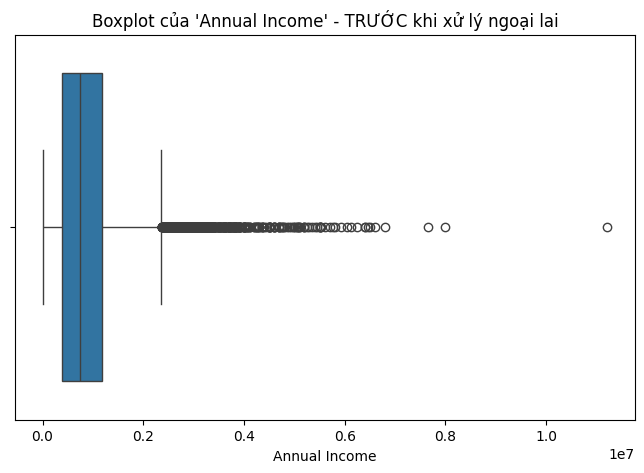

Q1: 386000.00, Q3: 1176000.00, IQR: 790000.00
Giới hạn dưới (Lower Bound): -799000.00
Giới hạn trên (Upper Bound): 2361000.00
Tìm thấy 815 giá trị ngoại lai.
Áp dụng Capping: Thay thế ngoại lai bằng giới hạn -799000.00 và 2361000.00.


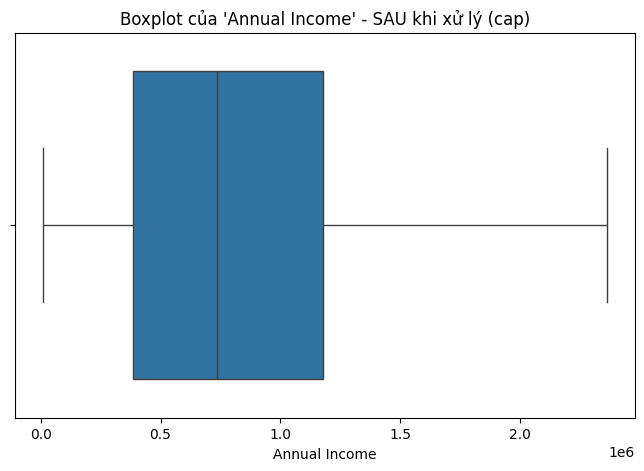


--- Xử lý Giá trị Ngoại lai cho Cột: 'Price ($)' (Phương pháp: cap) ---


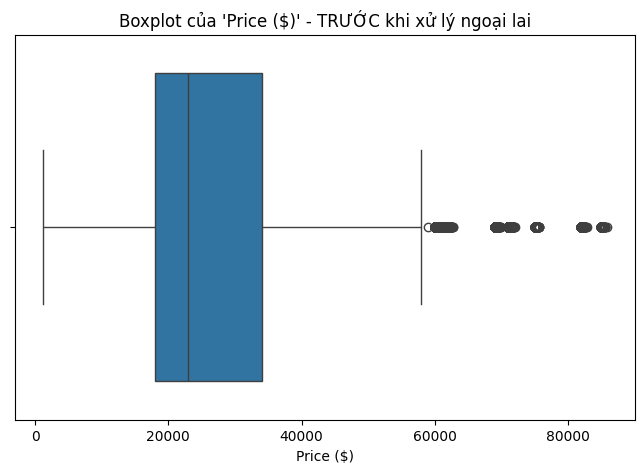

Q1: 18001.00, Q3: 34000.00, IQR: 15999.00
Giới hạn dưới (Lower Bound): -5997.50
Giới hạn trên (Upper Bound): 57998.50
Tìm thấy 1449 giá trị ngoại lai.
Áp dụng Capping: Thay thế ngoại lai bằng giới hạn -5997.50 và 57998.50.


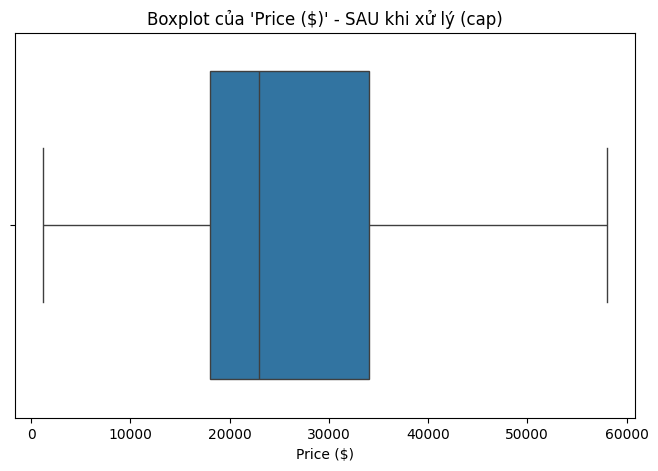

Số lượng hãng xe (lớp) duy nhất: 30
Numerical columns for preprocessing: ['Annual Income', 'Price ($)']
Categorical columns for preprocessing: ['Transmission', 'Color', 'Body Style', 'Dealer_Region']


In [24]:

# 1. Tiền xử lý dữ liệu
data = handle_missing_values(data)
data = remove_duplicates(data)
        # Xử lý Outliter
print("\n--- Bắt đầu Xử lý Giá trị Ngoại lai ---")
numerical_cols =data.drop(columns=(['Phone'])).select_dtypes(include=np.number).columns.tolist()
df_after_outliers = data.copy() # Làm việc trên bản sao
for col_name in numerical_cols:
    # Chọn phương pháp xử lý phù hợp cho từng cột hoặc một phương pháp chung
    # Ví dụ, dùng 'cap' cho hầu hết các trường hợp
    data = detect_and_treat_outliers_iqr(df_after_outliers, col_name, treatment_method='cap', factor=1.5)
features_to_drop_initial = ['Car_id', 'Date', 'Customer Name', 'Phone', 'Dealer_Name', 'Dealer_No ', 'Engine', 'Model', 'Gender']
    # Loại bỏ các cột không tồn tại khỏi features_to_drop để tránh lỗi
features_to_drop = [col for col in features_to_drop_initial if col in data.columns]

    # Chọn biến độc lập (X) và biến mục tiêu (y)
    # X sẽ được tạo sau khi drop 'Company' và các features_to_drop từ data_cleaned
if 'Company' not in data.columns:
    print("Lỗi: Không tìm thấy cột 'Company' (biến mục tiêu).")
    exit()
y_series = data['Company']
X_df = data.drop(columns=['Company'] + features_to_drop, errors='ignore')

    # Kiểm tra số lớp trong cột mục tiêu 'Company'
num_classes = y_series.nunique()
print(f"Số lượng hãng xe (lớp) duy nhất: {num_classes}")
if num_classes < 2:
    raise ValueError("Cần ít nhất 2 lớp cho bài toán phân loại.")  
 
    # Mã hóa biến mục tiêu
le = LabelEncoder()
y_encoded = le.fit_transform(y_series)

    # Xác định các cột số và cột hạng mục cho ColumnTransformer
numerical_cols = X_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Numerical columns for preprocessing: {numerical_cols}")
print(f"Categorical columns for preprocessing: {categorical_cols}")



    # Tạo pipeline tiền xử lý với ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

#### Chia dữ liệu

In [25]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_df, y_encoded, test_size=0.2, random_state=50, stratify=y_encoded if num_classes > 1 else None
)

#### Kiểm tra bộ dữ liệu sau khi đã cân bằng lớp


--- Phân tích Cân bằng Lớp cho Biến Mục tiêu 'Company' ---

--- Phân tích Cân bằng Lớp cho Biến 'Company' ---

Số lượng và Tỷ lệ phần trăm của mỗi lớp:
         Class  Count  Percentage (%)
0    Chevrolet   1819        7.609287
1        Dodge   1670        6.985986
2         Ford   1614        6.751726
3   Volkswagen   1333        5.576239
4   Mercedes-B   1285        5.375444
5   Mitsubishi   1277        5.341979
6     Chrysler   1120        4.685212
7   Oldsmobile   1111        4.647563
8       Toyota   1110        4.643380
9       Nissan    886        3.706338
10     Mercury    874        3.656139
11       Lexus    802        3.354947
12     Pontiac    796        3.329847
13         BMW    790        3.304748
14       Volvo    789        3.300565
15       Honda    708        2.961723
16       Acura    689        2.882242
17    Cadillac    652        2.727463
18    Plymouth    617        2.581050
19      Saturn    586        2.451370
20     Lincoln    492        2.058147
21        A

C:\Users\Admin\AppData\Local\Temp\ipykernel_18676\3297534815.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Class', y='Count', data=class_counts, palette='viridis')


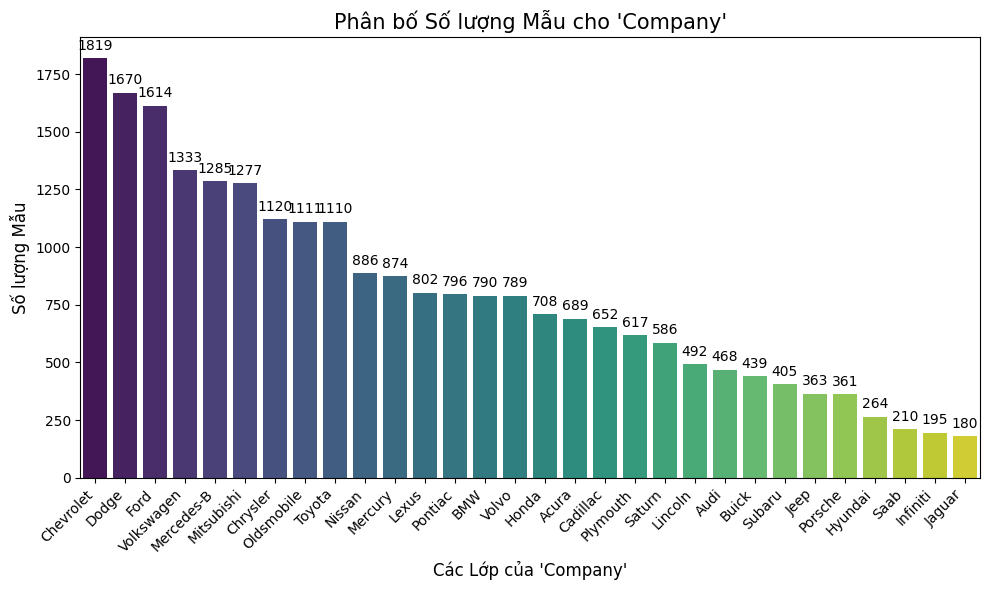


--- Phân tích Cân bằng Lớp cho Biến 'Company' ---

Số lượng và Tỷ lệ phần trăm của mỗi lớp:
    Class  Count  Percentage (%)
0       0   1455        3.333333
1       8   1455        3.333333
2       4   1455        3.333333
3      29   1455        3.333333
4      19   1455        3.333333
5       7   1455        3.333333
6      27   1455        3.333333
7      13   1455        3.333333
8      28   1455        3.333333
9       5   1455        3.333333
10     15   1455        3.333333
11     17   1455        3.333333
12      9   1455        3.333333
13     25   1455        3.333333
14      6   1455        3.333333
15      2   1455        3.333333
16     22   1455        3.333333
17     18   1455        3.333333
18     23   1455        3.333333
19     26   1455        3.333333
20     14   1455        3.333333
21     20   1455        3.333333
22      1   1455        3.333333
23     11   1455        3.333333
24     21   1455        3.333333
25      3   1455        3.333333
26     16   1455

C:\Users\Admin\AppData\Local\Temp\ipykernel_18676\3297534815.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Class', y='Count', data=class_counts, palette='viridis')


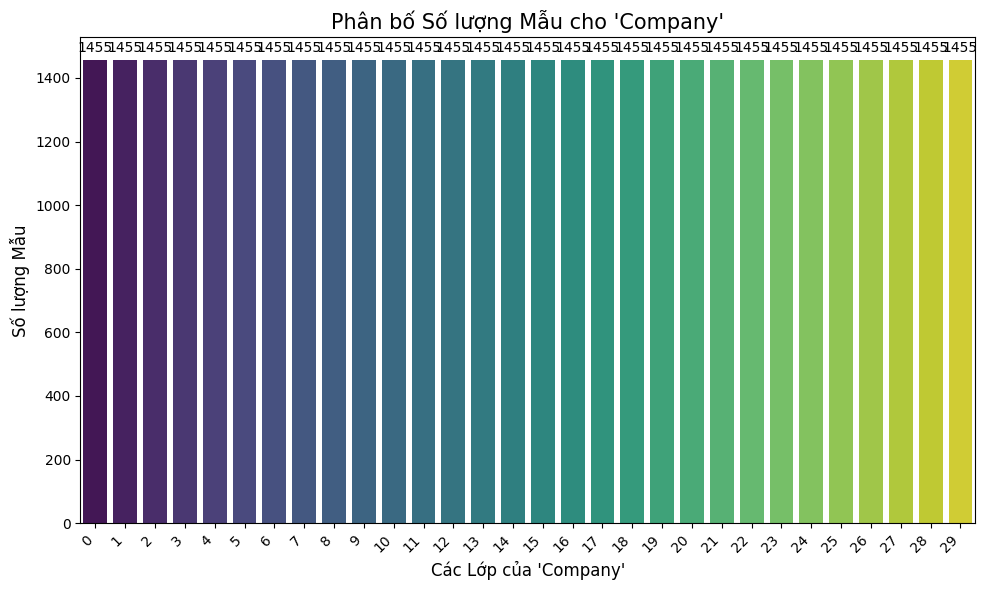

In [26]:
#Kiểm tra cân bằng lớp cho biến mục tiêu
print("\n--- Phân tích Cân bằng Lớp cho Biến Mục tiêu 'Company' ---")
company_balance_report_df = check_class_balance(y_series, target_name="Company")

#Tập X_train_val, y_train_val sẽ được dùng cho GridSearchCV (nó sẽ tự chia CV)
#Xử lý mất cân bằng lớp
ros = RandomOverSampler(random_state=42)
X_train_val, y_train_val = ros.fit_resample(X_train_val, y_train_val)
company_balance_report_df = check_class_balance(y_train_val, target_name="Company")

## 1. Logistic Regression (Baseline)

In [27]:
from sklearn.linear_model import LogisticRegression
model_log = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))])
model_log.fit(X_train_val, y_train_val)

print("\n--- Đánh giá Mô hình Cuối cùng trên Tập Test ---")
y_pred_encoded_test = model_log.predict(X_test) # X_test là dữ liệu gốc trước preprocessor
# Chuyển đổi y_pred và y_test về nhãn gốc để dễ đọc báo cáo
y_pred_labels_test = le.inverse_transform(y_pred_encoded_test)
y_test_labels = le.inverse_transform(y_test)
print("\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_encoded_test):.4f}")

print("\nClassification Report (nhãn gốc) trên tập kiểm tra:")
target_names_ordered = le.classes_
print(classification_report(y_test_labels, y_pred_labels_test, labels=target_names_ordered, zero_division=0))

C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Đánh giá Mô hình Cuối cùng trên Tập Test ---

Đánh giá mô hình trên tập kiểm tra:
Accuracy: 0.0780

Classification Report (nhãn gốc) trên tập kiểm tra:
              precision    recall  f1-score   support

       Acura       0.19      0.14      0.16       138
        Audi       0.08      0.41      0.13        94
         BMW       0.15      0.08      0.10       158
       Buick       0.08      0.34      0.13        88
    Cadillac       0.13      0.11      0.12       130
   Chevrolet       0.19      0.02      0.03       364
    Chrysler       0.14      0.06      0.08       224
       Dodge       0.00      0.00      0.00       334
        Ford       0.00      0.00      0.00       323
       Honda       0.05      0.03      0.04       142
     Hyundai       0.07      0.55      0.13        53
    Infiniti       0.05      0.62      0.09        39
      Jaguar       0.07      0.92      0.13        36
        Jeep       0.06      0.40      0.10        73
       Lexus       0.26      0.0

## 2. Decission Tree

In [48]:
from sklearn.tree import DecisionTreeClassifier
model_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        criterion='gini',          # Hoặc 'entropy'
        max_depth=None,            # Có thể giới hạn để tránh overfitting
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        class_weight='balanced'
    ))
])
model_dt.fit(X_train_val, y_train_val)

print("\n--- Đánh giá Mô hình Cuối cùng trên Tập Test ---")
y_pred_encoded_test = model_dt.predict(X_test) # X_test là dữ liệu gốc trước preprocessor
# Chuyển đổi y_pred và y_test về nhãn gốc để dễ đọc báo cáo
y_pred_labels_test = le.inverse_transform(y_pred_encoded_test)
y_test_labels = le.inverse_transform(y_test)
print("\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_encoded_test):.4f}")

print("\nClassification Report (nhãn gốc) trên tập kiểm tra:")
target_names_ordered = le.classes_
print(classification_report(y_test_labels, y_pred_labels_test, labels=target_names_ordered, zero_division=0))


--- Đánh giá Mô hình Cuối cùng trên Tập Test ---

Đánh giá mô hình trên tập kiểm tra:
Accuracy: 0.5810

Classification Report (nhãn gốc) trên tập kiểm tra:
              precision    recall  f1-score   support

       Acura       0.73      0.77      0.75       138
        Audi       0.57      0.63      0.60        94
         BMW       0.45      0.46      0.45       158
       Buick       0.73      0.70      0.72        88
    Cadillac       0.69      0.74      0.71       130
   Chevrolet       0.56      0.52      0.54       364
    Chrysler       0.53      0.56      0.55       224
       Dodge       0.58      0.59      0.58       334
        Ford       0.58      0.58      0.58       323
       Honda       0.60      0.54      0.57       142
     Hyundai       0.54      0.64      0.59        53
    Infiniti       0.43      0.51      0.47        39
      Jaguar       0.45      0.56      0.50        36
        Jeep       0.63      0.58      0.60        73
       Lexus       0.63      0.5

## 3. KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = Pipeline(steps=[
    ('preprocessor', preprocessor), # StandardScaler trong preprocessor rất quan trọng cho KNN
    ('classifier', KNeighborsClassifier(
        n_neighbors=5,             # Số láng giềng
        weights='uniform',         # Hoặc 'distance'
        metric='minkowski'         # Hoặc 'euclidean', 'manhattan'
    ))
])
model_knn.fit(X_train_val, y_train_val)

print("\n--- Đánh giá Mô hình Cuối cùng trên Tập Test ---")
y_pred_encoded_test_knn = model_knn.predict(X_test) # X_test là dữ liệu gốc trước preprocessor
# Chuyển đổi y_pred và y_test về nhãn gốc để dễ đọc báo cáo
y_pred_labels_test_knn = le.inverse_transform(y_pred_encoded_test_knn)
y_test_labels = le.inverse_transform(y_test)
print("\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_encoded_test_knn):.4f}")

print("\nClassification Report (nhãn gốc) trên tập kiểm tra:")
target_names_ordered = le.classes_
print(classification_report(y_test_labels, y_pred_labels_test, labels=target_names_ordered, zero_division=0))


--- Đánh giá Mô hình Cuối cùng trên Tập Test ---

Đánh giá mô hình trên tập kiểm tra:
Accuracy: 0.3008

Classification Report (nhãn gốc) trên tập kiểm tra:
              precision    recall  f1-score   support

       Acura       0.25      0.49      0.33       138
        Audi       0.17      0.59      0.26        94
         BMW       0.31      0.27      0.29       158
       Buick       0.30      0.52      0.38        88
    Cadillac       0.29      0.23      0.26       130
   Chevrolet       0.17      0.02      0.04       364
    Chrysler       0.23      0.13      0.17       224
       Dodge       0.38      0.12      0.18       334
        Ford       0.54      0.22      0.32       323
       Honda       0.27      0.39      0.32       142
     Hyundai       0.13      0.75      0.22        53
    Infiniti       0.10      0.44      0.16        39
      Jaguar       0.15      0.86      0.26        36
        Jeep       0.09      0.26      0.13        73
       Lexus       0.33      0.4

## 4. RandomForest

In [30]:
model_ran=Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=50, class_weight='balanced'))])
model_ran.fit(X_train_val, y_train_val)

print("\n--- Đánh giá Mô hình Cuối cùng trên Tập Test ---")
y_pred_encoded_test = model_ran.predict(X_test) # X_test là dữ liệu gốc trước preprocessor
# Chuyển đổi y_pred và y_test về nhãn gốc để dễ đọc báo cáo
y_pred_labels_test = le.inverse_transform(y_pred_encoded_test)
y_test_labels = le.inverse_transform(y_test)
print("\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_encoded_test):.4f}")

print("\nClassification Report (nhãn gốc) trên tập kiểm tra:")
target_names_ordered = le.classes_
print(classification_report(y_test_labels, y_pred_labels_test, labels=target_names_ordered, zero_division=0))


--- Đánh giá Mô hình Cuối cùng trên Tập Test ---

Đánh giá mô hình trên tập kiểm tra:
Accuracy: 0.4915

Classification Report (nhãn gốc) trên tập kiểm tra:
              precision    recall  f1-score   support

       Acura       0.64      0.72      0.68       138
        Audi       0.50      0.62      0.56        94
         BMW       0.42      0.42      0.42       158
       Buick       0.62      0.60      0.61        88
    Cadillac       0.57      0.58      0.57       130
   Chevrolet       0.48      0.39      0.43       364
    Chrysler       0.47      0.44      0.46       224
       Dodge       0.48      0.47      0.47       334
        Ford       0.50      0.47      0.48       323
       Honda       0.55      0.56      0.56       142
     Hyundai       0.59      0.60      0.60        53
    Infiniti       0.40      0.46      0.43        39
      Jaguar       0.42      0.58      0.49        36
        Jeep       0.42      0.44      0.43        73
       Lexus       0.49      0.5

## 5. XGBoost

In [37]:
from xgboost import XGBClassifier
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softmax', # Hoặc 'multi:softprob'
        num_class=num_classes,
        eval_metric='mlogloss',
        use_label_encoder=False, # Khuyến nghị
        n_estimators=100,        # Sẽ được tune hoặc dùng early stopping
        learning_rate=0.1,
        random_state=42
        # Thêm các siêu tham số đã tune hoặc muốn thử
    ))
])
model_xgb.fit(X_train_val, y_train_val)

print("\n--- Đánh giá Mô hình Cuối cùng trên Tập Test ---")
y_pred_encoded_test_xgb = model_xgb.predict(X_test) # X_test là dữ liệu gốc trước preprocessor
# Chuyển đổi y_pred và y_test về nhãn gốc để dễ đọc báo cáo
y_pred_labels_test_xgb = le.inverse_transform(y_pred_encoded_test_xgb)
y_test_labels = le.inverse_transform(y_test)
print("\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_encoded_test_xgb):.4f}")

print("\nClassification Report (nhãn gốc) trên tập kiểm tra:")
target_names_ordered = le.classes_
print(classification_report(y_test_labels, y_pred_labels_test, labels=target_names_ordered, zero_division=0))

C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [22:28:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Đánh giá Mô hình Cuối cùng trên Tập Test ---

Đánh giá mô hình trên tập kiểm tra:
Accuracy: 0.6061

Classification Report (nhãn gốc) trên tập kiểm tra:
              precision    recall  f1-score   support

       Acura       0.25      0.49      0.33       138
        Audi       0.17      0.59      0.26        94
         BMW       0.31      0.27      0.29       158
       Buick       0.30      0.52      0.38        88
    Cadillac       0.29      0.23      0.26       130
   Chevrolet       0.17      0.02      0.04       364
    Chrysler       0.23      0.13      0.17       224
       Dodge       0.38      0.12      0.18       334
        Ford       0.54      0.22      0.32       323
       Honda       0.27      0.39      0.32       142
     Hyundai       0.13      0.75      0.22        53
    Infiniti       0.10      0.44      0.16        39
      Jaguar       0.15      0.86      0.26        36
        Jeep       0.09      0.26      0.13        73
       Lexus       0.33      0.4

## 6. LightGBM

In [44]:
from lightgbm import LGBMClassifier

model_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor), # OneHotEncode trước cho LGBM của scikit-learn
    ('classifier', LGBMClassifier(
        objective='multiclass',
        num_class=num_classes,
        metric='multi_logloss', # Hoặc 'multi_error'
        n_estimators=100,
        learning_rate=0.1
    ))
])
model_lgbm.fit(X_train_val, y_train_val)
print("\n--- Đánh giá Mô hình Cuối cùng trên Tập Test ---")
y_pred_encoded_test_lgbm = model_lgbm.predict(X_test) # X_test là dữ liệu gốc trước preprocessor
# Chuyển đổi y_pred và y_test về nhãn gốc để dễ đọc báo cáo
y_pred_labels_test_lgbm = le.inverse_transform(y_pred_encoded_test_lgbm)
y_test_labels = le.inverse_transform(y_test)
print("\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_encoded_test_lgbm):.4f}")

print("\nClassification Report (nhãn gốc) trên tập kiểm tra:")
target_names_ordered = le.classes_
print(classification_report(y_test_labels, y_pred_labels_test_lgbm, labels=target_names_ordered, zero_division=0))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 43650, number of used features: 19
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197


C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 7. CatBoost

In [42]:
from catboost import CatBoostClassifier
model_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor), # CatBoost có thể xử lý hạng mục tốt hơn,
                                   # nhưng dùng preprocessor để nhất quán
    ('classifier', CatBoostClassifier(
        objective='MultiClass',    # Hoặc 'MultiClassOneVsAll'
        eval_metric='MultiClass',  # Hoặc 'Accuracy', 'F1'
        iterations=100,            # Tương đương n_estimators
        learning_rate=0.1,
        random_state=42,
        verbose=0,                 # Tắt bớt log
        auto_class_weights='Balanced' # Nếu cần
        # CatBoost xử lý biến hạng mục rất tốt, bạn có thể truyền X_df gốc
        # và chỉ định cat_features trong CatBoostClassifier nếu không dùng preprocessor
    ))
])
model_catboost.fit(X_train_val, y_train_val)
print("\n--- Đánh giá Mô hình Cuối cùng trên Tập Test ---")
y_pred_encoded_test_catboost = model_catboost.predict(X_test) # X_test là dữ liệu gốc trước preprocessor
# Chuyển đổi y_pred và y_test về nhãn gốc để dễ đọc báo cáo
y_pred_labels_test_catboost = le.inverse_transform(y_pred_encoded_test_catboost)
y_test_labels = le.inverse_transform(y_test)
print("\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_encoded_test_catboost):.4f}")

print("\nClassification Report (nhãn gốc) trên tập kiểm tra:")
target_names_ordered = le.classes_
print(classification_report(y_test_labels, y_pred_labels_test, labels=target_names_ordered, zero_division=0))


--- Đánh giá Mô hình Cuối cùng trên Tập Test ---

Đánh giá mô hình trên tập kiểm tra:
Accuracy: 0.5633

Classification Report (nhãn gốc) trên tập kiểm tra:
              precision    recall  f1-score   support

       Acura       0.25      0.49      0.33       138
        Audi       0.17      0.59      0.26        94
         BMW       0.31      0.27      0.29       158
       Buick       0.30      0.52      0.38        88
    Cadillac       0.29      0.23      0.26       130
   Chevrolet       0.17      0.02      0.04       364
    Chrysler       0.23      0.13      0.17       224
       Dodge       0.38      0.12      0.18       334
        Ford       0.54      0.22      0.32       323
       Honda       0.27      0.39      0.32       142
     Hyundai       0.13      0.75      0.22        53
    Infiniti       0.10      0.44      0.16        39
      Jaguar       0.15      0.86      0.26        36
        Jeep       0.09      0.26      0.13        73
       Lexus       0.33      0.4

C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 8. SVM

In [34]:
from sklearn.svm import SVC
model_svc = Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier',SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovr'))])
model_svc.fit(X_train_val, y_train_val)
print("\n--- Đánh giá Mô hình Cuối cùng trên Tập Test ---")
y_pred_encoded_test = model_svc.predict(X_test) # X_test là dữ liệu gốc trước preprocessor
# Chuyển đổi y_pred và y_test về nhãn gốc để dễ đọc báo cáo
y_pred_labels_test = le.inverse_transform(y_pred_encoded_test)
y_test_labels = le.inverse_transform(y_test)
print("\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_encoded_test):.4f}")

print("\nClassification Report (nhãn gốc) trên tập kiểm tra:")
target_names_ordered = le.classes_
print(classification_report(y_test_labels, y_pred_labels_test, labels=target_names_ordered, zero_division=0))


--- Đánh giá Mô hình Cuối cùng trên Tập Test ---

Đánh giá mô hình trên tập kiểm tra:
Accuracy: 0.2529

Classification Report (nhãn gốc) trên tập kiểm tra:
              precision    recall  f1-score   support

       Acura       0.25      0.49      0.33       138
        Audi       0.17      0.59      0.26        94
         BMW       0.31      0.27      0.29       158
       Buick       0.30      0.52      0.38        88
    Cadillac       0.29      0.23      0.26       130
   Chevrolet       0.17      0.02      0.04       364
    Chrysler       0.23      0.13      0.17       224
       Dodge       0.38      0.12      0.18       334
        Ford       0.54      0.22      0.32       323
       Honda       0.27      0.39      0.32       142
     Hyundai       0.13      0.75      0.22        53
    Infiniti       0.10      0.44      0.16        39
      Jaguar       0.15      0.86      0.26        36
        Jeep       0.09      0.26      0.13        73
       Lexus       0.33      0.4

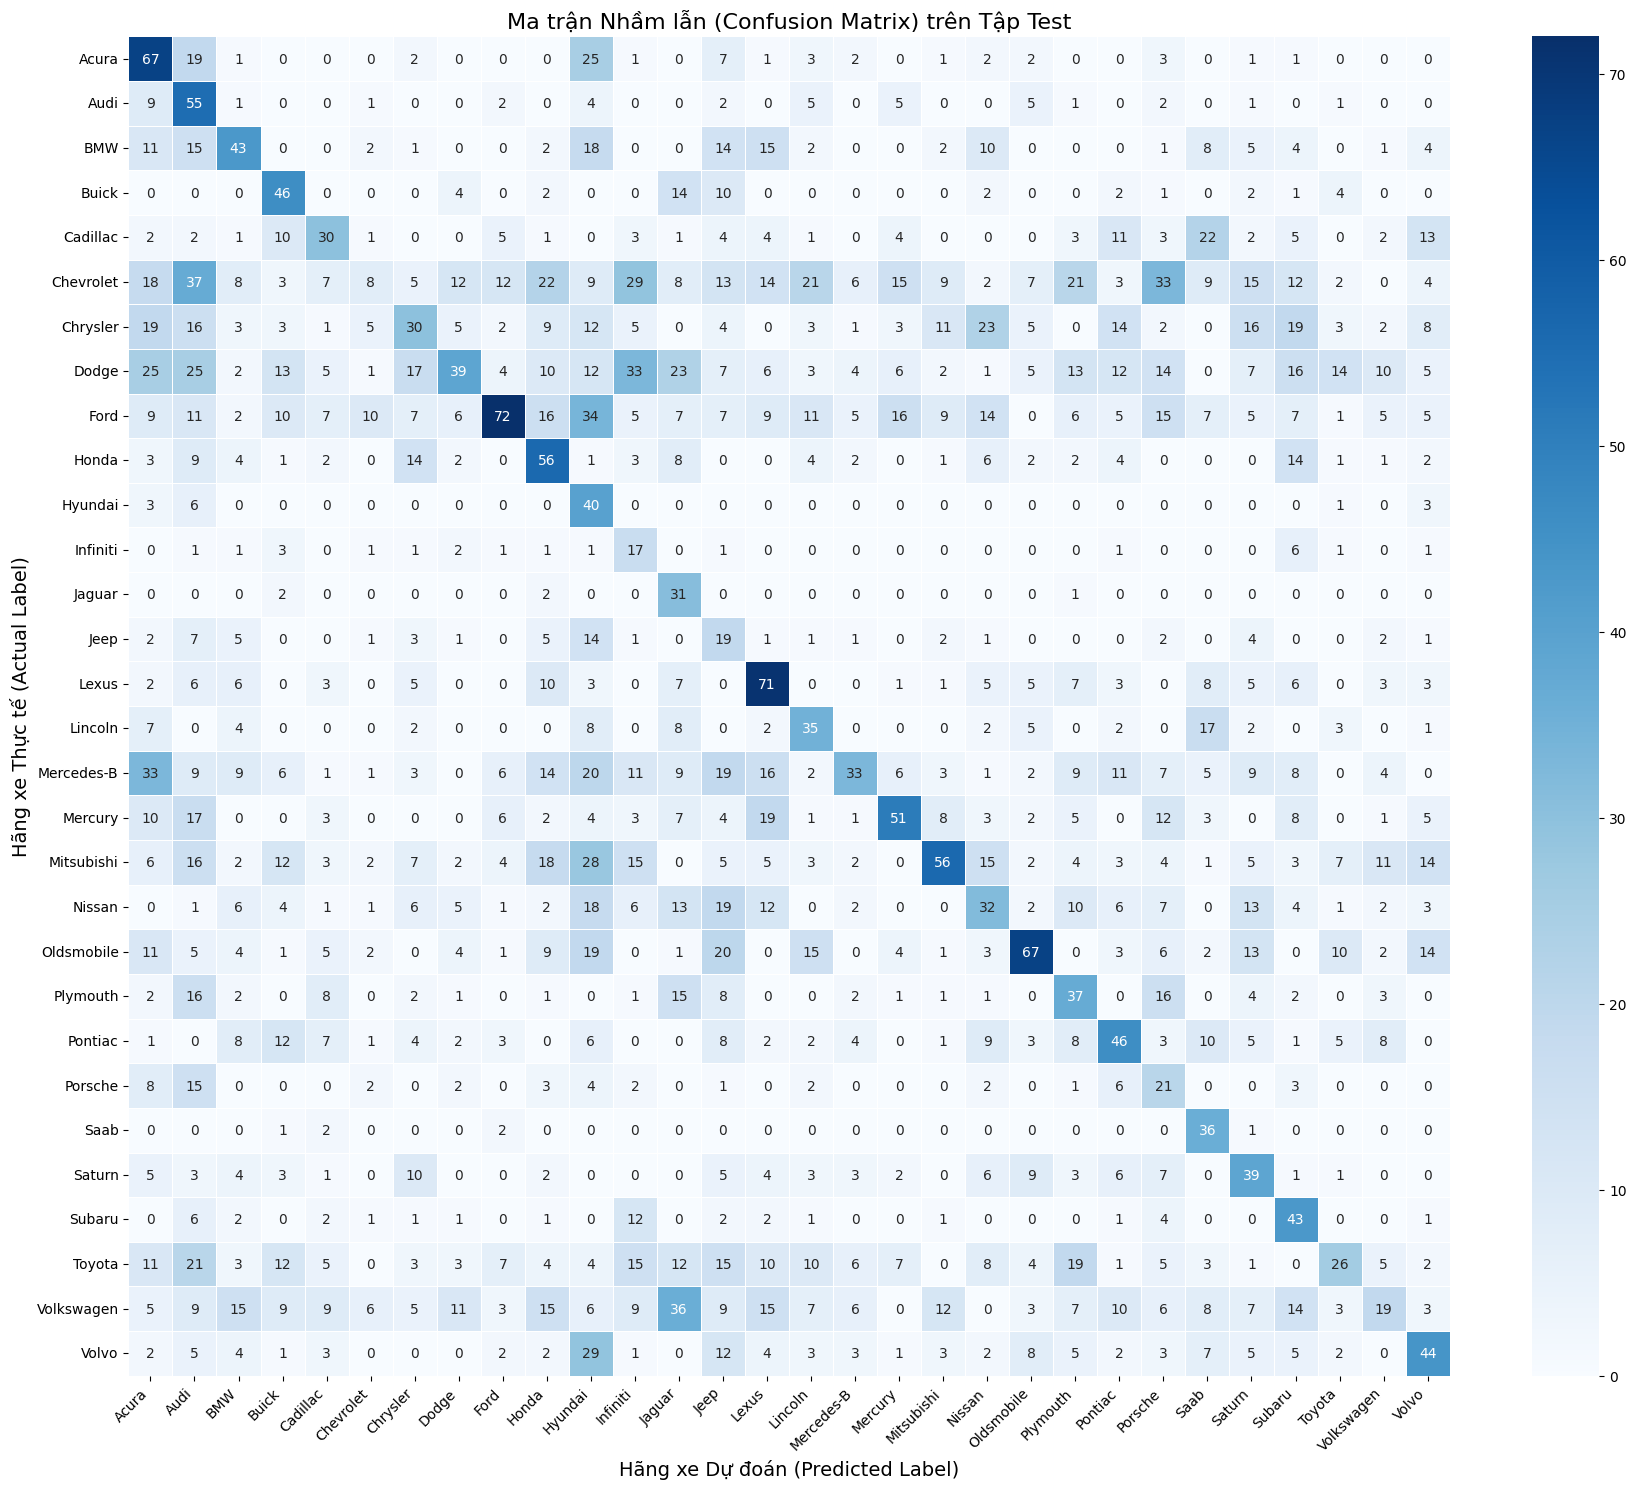


Lưu ý khi đọc Ma trận Nhầm lẫn:
- Các giá trị trên đường chéo chính là số lượng dự đoán đúng cho mỗi hãng xe.
- Các giá trị ngoài đường chéo chính thể hiện số lượng mẫu của hãng xe ở hàng bị dự đoán nhầm thành hãng xe ở cột.


In [35]:
cm = confusion_matrix(y_test, y_pred_encoded_test, labels=le.transform(target_names_ordered))
cm_df = pd.DataFrame(cm,
                     index = target_names_ordered, # Nhãn thực tế (hàng)
                     columns = target_names_ordered) # Nhãn dự đoán (cột)

# Vẽ heatmap
plt.figure(figsize=(18, 15)) # Điều chỉnh kích thước cho phù hợp với số lượng lớp
sns.heatmap(cm_df,
            annot=True,      # Hiển thị số lượng trong từng ô
            fmt='d',         # Định dạng số nguyên
            cmap='Blues',    # Bảng màu (bạn có thể chọn 'viridis', 'coolwarm', v.v.)
            linewidths=.5,   # Đường kẻ giữa các ô
            cbar=True)       # Hiển thị thanh màu

plt.title('Ma trận Nhầm lẫn (Confusion Matrix) trên Tập Test', fontsize=16)
plt.ylabel('Hãng xe Thực tế (Actual Label)', fontsize=14)
plt.xlabel('Hãng xe Dự đoán (Predicted Label)', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout() # Tự động điều chỉnh để vừa vặn
plt.show()

print("\nLưu ý khi đọc Ma trận Nhầm lẫn:")
print("- Các giá trị trên đường chéo chính là số lượng dự đoán đúng cho mỗi hãng xe.")
print("- Các giá trị ngoài đường chéo chính thể hiện số lượng mẫu của hãng xe ở hàng bị dự đoán nhầm thành hãng xe ở cột.")

## Tìm siêu tham số cho top 3 mô hình tốt nhất

#### 1. Decission Tree

In [49]:
def tune_decision_tree_hyperparameters(X_data, y_data, preprocessor_pipeline, param_grid=None, cv_folds=5, scoring_metric='f1_weighted'):
    """
    Hiệu chỉnh siêu tham số cho DecisionTreeClassifier sử dụng GridSearchCV.

    Args:
        X_data (pd.DataFrame): Dữ liệu đặc trưng gốc.
        y_data (pd.Series or np.array): Biến mục tiêu đã mã hóa.
        preprocessor_pipeline (ColumnTransformer): Pipeline tiền xử lý.
        param_grid (dict, optional): Lưới siêu tham số.
        cv_folds (int): Số fold CV.
        scoring_metric (str): Metric đánh giá.

    Returns:
        GridSearchCV: Đối tượng GridSearchCV đã fit.
        pd.DataFrame: DataFrame kết quả tốt nhất.
    """
    if X_data.empty or len(y_data) == 0:
        print("Lỗi: Dữ liệu X hoặc y rỗng cho tuning Decision Tree.")
        return None, None

    if param_grid is None:
        param_grid = {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [None, 5, 10, 15, 20],
            'classifier__min_samples_split': [2, 5, 10, 20],
            'classifier__min_samples_leaf': [1, 2, 5, 10],
            'classifier__max_features': [None, 'sqrt', 'log2']
            # 'classifier__class_weight': [None, 'balanced'] # Nếu cần
        }
        if X_data.shape[0] < 300: # Giảm grid cho dữ liệu nhỏ
             param_grid = {
                'classifier__criterion': ['gini'],
                'classifier__max_depth': [None, 5, 10],
                'classifier__min_samples_split': [2, 5],
                'classifier__min_samples_leaf': [1, 2],
            }

    print(f"Bắt đầu GridSearchCV cho Decision Tree với lưới tham số: {param_grid}")
    print(f"Số fold CV: {cv_folds}, Metric đánh giá: {scoring_metric}")

    dt_model_for_tuning = DecisionTreeClassifier(random_state=42, class_weight='balanced' if len(np.unique(y_data)) > 1 else None)
    full_pipeline_for_tuning = Pipeline(steps=[('preprocessor', preprocessor_pipeline),
                                               ('classifier', dt_model_for_tuning)])

    min_class_count = pd.Series(y_data).value_counts().min()
    actual_cv_folds = min(cv_folds, min_class_count)
    if actual_cv_folds < 2:
        print(f"Cảnh báo: Lớp nhỏ nhất có {min_class_count} mẫu. Sử dụng CV mặc định.")
        cv_strategy = None
    else:
        if actual_cv_folds < cv_folds:
            print(f"Cảnh báo: Giảm số fold CV xuống {actual_cv_folds}.")
        cv_strategy = StratifiedKFold(n_splits=actual_cv_folds, shuffle=True, random_state=42)

    grid_search_dt = GridSearchCV(estimator=full_pipeline_for_tuning,
                                  param_grid=param_grid,
                                  cv=cv_strategy,
                                  scoring=scoring_metric,
                                  verbose=1,
                                  n_jobs=-1,
                                  return_train_score=True)
    try:
        grid_search_dt.fit(X_data, y_data)
    except Exception as e:
        print(f"Lỗi trong GridSearchCV cho Decision Tree: {e}")
        return None, None

    print("\nGridSearchCV cho Decision Tree hoàn tất.")
    print(f"Siêu tham số tốt nhất: {grid_search_dt.best_params_}")
    print(f"Điểm {scoring_metric} tốt nhất (CV): {grid_search_dt.best_score_:.4f}")

    results_df = pd.DataFrame(grid_search_dt.cv_results_)
    best_results_df = results_df.sort_values(by='rank_test_score').head()
    return grid_search_dt, best_results_df

#### 2. LightGBM 

In [54]:
def tune_lgbm_hyperparameters(X_data, y_data, preprocessor_pipeline, num_classes, param_grid=None, cv_folds=5, scoring_metric='f1_weighted'):
    """
    Hiệu chỉnh siêu tham số cho LGBMClassifier sử dụng GridSearchCV.
    Early stopping sẽ được áp dụng khi huấn luyện mô hình cuối cùng với best_params.

    Args:
        X_data (pd.DataFrame): Dữ liệu đặc trưng gốc.
        y_data (pd.Series or np.array): Biến mục tiêu đã mã hóa.
        preprocessor_pipeline (ColumnTransformer): Pipeline tiền xử lý.
        num_classes (int): Số lượng lớp.
        param_grid (dict, optional): Lưới siêu tham số.
        cv_folds (int): Số fold CV.
        scoring_metric (str): Metric đánh giá.

    Returns:
        GridSearchCV: Đối tượng GridSearchCV đã fit.
        pd.DataFrame: DataFrame kết quả tốt nhất.
    """
    if X_data.empty or len(y_data) == 0:
        print("Lỗi: Dữ liệu X hoặc y rỗng cho tuning LightGBM.")
        return None, None

    if param_grid is None:
        param_grid = {
            'classifier__n_estimators': [200, 300], # Sẽ được tinh chỉnh thêm bằng early stopping
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__max_depth': [5, 10], # -1 là không giới hạn
            # 'classifier__num_leaves': [40, 50], # Thường < 2^max_depth
            # 'classifier__reg_alpha': [0, 0.01, 0.1], # L1
            # 'classifier__reg_lambda': [0, 0.01, 0.1]  # L2
        }
        if X_data.shape[0] < 300: # Giảm grid
            param_grid = {
                'classifier__n_estimators': [100, 150],
                'classifier__learning_rate': [0.05, 0.1],
                'classifier__max_depth': [-1, 10],
                'classifier__num_leaves': [20, 31],
            }

    print(f"Bắt đầu GridSearchCV cho LightGBM với lưới tham số: {param_grid}")
    print(f"Số fold CV: {cv_folds}, Metric đánh giá: {scoring_metric}")

    lgbm_model_for_tuning = LGBMClassifier(
        objective='multiclass',
        num_class=num_classes,
        metric='multi_logloss', # Metric cho LightGBM, scoring của CV là riêng
        random_state=42,
        class_weight='balanced', # Nếu cần
        # force_col_wise=True, # Có thể cần nếu có cảnh báo
        # verbosity=-1 # Tắt bớt log của LightGBM
    )
    full_pipeline_for_tuning = Pipeline(steps=[('preprocessor', preprocessor_pipeline),
                                               ('classifier', lgbm_model_for_tuning)])

    min_class_count = pd.Series(y_data).value_counts().min()
    actual_cv_folds = min(cv_folds, min_class_count)
    if actual_cv_folds < 2:
        print(f"Cảnh báo: Lớp nhỏ nhất có {min_class_count} mẫu. Sử dụng CV mặc định.")
        cv_strategy = None
    else:
        if actual_cv_folds < cv_folds:
             print(f"Cảnh báo: Giảm số fold CV xuống {actual_cv_folds}.")
        cv_strategy = StratifiedKFold(n_splits=actual_cv_folds, shuffle=True, random_state=42)

    grid_search_lgbm = GridSearchCV(estimator=full_pipeline_for_tuning,
                                    param_grid=param_grid,
                                    cv=cv_strategy,
                                    scoring=scoring_metric,
                                    verbose=1,
                                    n_jobs=-1,
                                    return_train_score=True)
    try:
        grid_search_lgbm.fit(X_data, y_data) # X_data là dữ liệu gốc
    except Exception as e:
        print(f"Lỗi trong GridSearchCV cho LightGBM: {e}")
        return None, None

    print("\nGridSearchCV cho LightGBM hoàn tất.")
    print(f"Siêu tham số tốt nhất (từ Grid): {grid_search_lgbm.best_params_}")
    print(f"Điểm {scoring_metric} tốt nhất (CV): {grid_search_lgbm.best_score_:.4f}")

    results_df = pd.DataFrame(grid_search_lgbm.cv_results_)
    best_results_df = results_df.sort_values(by='rank_test_score').head()
    return grid_search_lgbm, best_results_df

Tìm bộ tham số tối ưu

In [ ]:
# # 1. Tune Decision Tree
print("\n--- Hiệu chỉnh Siêu tham số cho Decision Tree ---")
grid_search_dt_obj, top_configs_dt = tune_decision_tree_hyperparameters(
    X_train_val, y_train_val, preprocessor, cv_folds=3, scoring_metric='f1_weighted'
)
if grid_search_dt_obj:
    best_dt_pipeline = grid_search_dt_obj.best_estimator_
    # Đánh giá best_dt_pipeline trên X_test, y_test

# # 2. Tune LightGBM (GridSearchCV tìm các params khác, n_estimators sẽ được tối ưu sau bằng early stopping)
print("\n--- Hiệu chỉnh Siêu tham số cho LightGBM (GridSearch) ---")
grid_search_lgbm_obj, top_configs_lgbm = tune_lgbm_hyperparameters(
    X_train_val, y_train_val, preprocessor, num_classes, cv_folds=3, scoring_metric='f1_weighted'
)

if grid_search_lgbm_obj:
    best_lgbm_params_from_grid = grid_search_lgbm_obj.best_params_
    print(f"Best LGBM params từ Grid (chưa có n_estimators tối ưu từ ES): {best_lgbm_params_from_grid}")


## Chạy lại mô hình với bộ tham số tìm được

#### 1. LigtGBM_tunned

In [56]:
from lightgbm import LGBMClassifier

model_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor), # OneHotEncode trước cho LGBM của scikit-learn
    ('classifier', LGBMClassifier(
        objective='multiclass',
        num_class=num_classes,
        metric='multi_logloss', # Hoặc 'multi_error'
        n_estimators=200,
        max_depth = 15,
        num_leaves = 40,
        learning_rate=0.1
    ))
])
model_lgbm.fit(X_train_val, y_train_val)
print("\n--- Đánh giá Mô hình Cuối cùng trên Tập Test ---")
y_pred_encoded_test_lgbm = model_lgbm.predict(X_test) # X_test là dữ liệu gốc trước preprocessor
# Chuyển đổi y_pred và y_test về nhãn gốc để dễ đọc báo cáo
y_pred_labels_test_lgbm = le.inverse_transform(y_pred_encoded_test_lgbm)
y_test_labels = le.inverse_transform(y_test)
print("\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_encoded_test_lgbm):.4f}")

print("\nClassification Report (nhãn gốc) trên tập kiểm tra:")
target_names_ordered = le.classes_
print(classification_report(y_test_labels, y_pred_labels_test_lgbm, labels=target_names_ordered, zero_division=0))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 43650, number of used features: 19
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197
[LightGBM] [Info] Start training from score -3.401197


C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Đánh giá mô hình trên tập kiểm tra:
Accuracy: 0.6103

Classification Report (nhãn gốc) trên tập kiểm tra:
              precision    recall  f1-score   support

       Acura       0.71      0.86      0.78       138
        Audi       0.64      0.74      0.69        94
         BMW       0.47      0.47      0.47       158
       Buick       0.70      0.66      0.68        88
    Cadillac       0.75      0.75      0.75       130
   Chevrolet       0.57      0.54      0.56       364
    Chrysler       0.54      0.60      0.57       224
       Dodge       0.63      0.60      0.62       334
        Ford       0.65      0.60      0.62       323
       Honda       0.63      0.54      0.58       142
     Hyundai       0.55      0.60      0.58        53
    Infiniti       0.59      0.51      0.55        39
      Jaguar       0.50      0.56      0.53        36
        Jeep       0.61      0.58      0.59        73
       Lexus       0.64      0.61      0.63       160
     Lincoln       0.65     

#### 2. Decission Tree_tunned

In [58]:
from sklearn.tree import DecisionTreeClassifier
model_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        criterion='gini',          # Hoặc 'entropy'
        max_depth=None,            # Có thể giới hạn để tránh overfitting
        min_samples_split=2,
        min_samples_leaf=1,
    ))
])
model_dt.fit(X_train_val, y_train_val)

print("\n--- Đánh giá Mô hình Cuối cùng trên Tập Test ---")
y_pred_encoded_test = model_dt.predict(X_test) # X_test là dữ liệu gốc trước preprocessor
# Chuyển đổi y_pred và y_test về nhãn gốc để dễ đọc báo cáo
y_pred_labels_test = le.inverse_transform(y_pred_encoded_test)
y_test_labels = le.inverse_transform(y_test)
print("\nĐánh giá mô hình trên tập kiểm tra:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_encoded_test):.4f}")

print("\nClassification Report (nhãn gốc) trên tập kiểm tra:")
target_names_ordered = le.classes_
print(classification_report(y_test_labels, y_pred_labels_test, labels=target_names_ordered, zero_division=0))


--- Đánh giá Mô hình Cuối cùng trên Tập Test ---

Đánh giá mô hình trên tập kiểm tra:
Accuracy: 0.5819

Classification Report (nhãn gốc) trên tập kiểm tra:
              precision    recall  f1-score   support

       Acura       0.73      0.76      0.74       138
        Audi       0.58      0.66      0.62        94
         BMW       0.47      0.48      0.48       158
       Buick       0.73      0.70      0.72        88
    Cadillac       0.68      0.75      0.71       130
   Chevrolet       0.56      0.52      0.54       364
    Chrysler       0.53      0.55      0.54       224
       Dodge       0.58      0.58      0.58       334
        Ford       0.58      0.57      0.57       323
       Honda       0.59      0.52      0.55       142
     Hyundai       0.53      0.64      0.58        53
    Infiniti       0.43      0.49      0.46        39
      Jaguar       0.47      0.61      0.53        36
        Jeep       0.59      0.58      0.58        73
       Lexus       0.64      0.6